In [5]:

import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [6]:
text = open('sherlock_holmes.txt', 'r', encoding='utf-8').read()

In [7]:
import re
text = re.sub(r'\n+', '~', text)
text = re.sub(r'\n', ' ', text)
print(text[:1000])

# Remove unwanted characters while retaining '.', and extra spaces
processed_text = re.sub('[^a-zA-Z0-9 \.~]', '', text)  # Remove unwanted characters except for . and ~
processed_text = re.sub(r'\.', ' . ', processed_text)  # add spaces
processed_text = re.sub(r'\s+', ' ', processed_text)  # Replace multiple spaces with a single space
processed_text = re.sub(r'~', '\n', processed_text)  # Replace multiple spaces with a single space

# Final cleanup to remove leading/trailing spaces
processed_text = processed_text.strip()


print(processed_text[:1000])

﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes,~by Arthur Conan Doyle~This eBook is for the use of anyone anywhere in the United States and~most other parts of the world at no cost and with almost no restrictions~whatsoever. You may copy it, give it away or re-use it under the terms~of the Project Gutenberg License included with this eBook or online at~www.gutenberg.org. If you are not located in the United States, you~will have to check the laws of the country where you are located before~using this eBook.~Title: The Adventures of Sherlock Holmes~Author: Arthur Conan Doyle~Release Date: November 29, 2002 [eBook #1661]~[Most recently updated: October 10, 2023]~Language: English~Character set encoding: UTF-8~Produced by: an anonymous Project Gutenberg volunteer and Jose Menendez~*** START OF THE PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK~HOLMES ***~The Adventures of Sherlock Holmes~by Arthur Conan Doyle~Contents~   I.     A Scandal in Bohemia~   II.    The Red

In [8]:
words = processed_text.split()
words_set = sorted(list(set(words)))
print(words_set[5000:5100])
stoi = {word: i for i, word in enumerate(words_set)}
itos = {i: word for word, i in stoi.items()}

print(stoi)
print(itos)
print(len(stoi))
print(len(itos))


['illnatured', 'illness', 'illservice', 'illtreatment', 'illtrimmed', 'illuminated', 'illusage', 'illused', 'illustrate', 'illustrious', 'imagination', 'imagine', 'imbecile', 'imbecility', 'imbedded', 'imitate', 'immediate', 'immediately', 'immense', 'immensely', 'imminent', 'impassable', 'impatience', 'impatient', 'impatiently', 'impending', 'imperilled', 'impersonal', 'impertinent', 'imperturbably', 'impetuousvolcanic', 'implacable', 'implicate', 'implicated', 'implicates', 'implicating', 'implicit', 'implied', 'implies', 'implore', 'implored', 'imploring', 'imply', 'importance', 'important', 'importers', 'imposed', 'imposing', 'impossibility', 'impossible', 'impressed', 'impression', 'impressions', 'impressive', 'imprisoned', 'imprisonment', 'improbabilities', 'improbable', 'improved', 'improving', 'improvisations', 'imprudence', 'imprudently', 'impulse', 'impulsive', 'impulsively', 'impunity', 'in', 'inaccurate', 'inadequate', 'inarticulate', 'inbreath', 'incalculable', 'incapable'

In [9]:
block_size = 15
X, Y = [], []


context = [0] * block_size


for word in words:

    ix = stoi[word]


    X.append(context[:])
    Y.append(ix)

    # print(' '.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

X.shape, Y.shape


(torch.Size([114040, 15]), torch.Size([114040]))

In [11]:
emb_dim = 128
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [12]:
emb.weight

Parameter containing:
tensor([[ 0.9384,  0.8854, -1.2355,  ...,  1.7710, -1.7966,  0.5109],
        [ 0.0049, -0.4415, -0.5087,  ...,  0.7601, -0.7166,  0.7421],
        [ 0.3167, -0.3306, -1.7676,  ...,  1.5606,  0.3415,  0.1077],
        ...,
        [ 1.3765,  2.3039,  0.2065,  ..., -0.2328,  0.6027, -0.2178],
        [ 1.3652, -1.0213, -1.0148,  ..., -1.1297, -1.0940,  0.7483],
        [ 0.7859,  0.6305,  0.3154,  ...,  0.5080,  2.1293,  1.8417]],
       requires_grad=True)

In [13]:
emb.weight.shape

torch.Size([9390, 128])

In [14]:
class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = torch.tanh(self.lin1(x))
        x = self.lin2(x)
        return x

# Defining the model
vocab_size = len(stoi)
emb_dim = 128
hidden_size = 1024

model = NextWord(block_size, vocab_size, emb_dim, hidden_size).to(device)
model = torch.compile(model)

for param_name, param in model.named_parameters():
    print(param_name, param.shape)


_orig_mod.emb.weight torch.Size([9390, 128])
_orig_mod.lin1.weight torch.Size([1024, 1920])
_orig_mod.lin1.bias torch.Size([1024])
_orig_mod.lin2.weight torch.Size([9390, 1024])
_orig_mod.lin2.bias torch.Size([9390])


In [15]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 7.5 MB/s eta 0:00:00


In [16]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [17]:
# Train the model
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.001)
batch_size = 1000
print_every = 50
elapsed_time = []

for epoch in range(500):
    for i in range(0, X.shape[0]-batch_size, batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]


        x = torch.clamp(x, 0, vocab_size - 1)
        y = torch.clamp(y, 0, vocab_size - 1)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    if epoch % print_every == 0:
        print(epoch, loss.item())

W1029 12:32:08.595000 1803 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT forward <ipython-input-14-e8dbfb6d7a03> line 8 
W1029 12:32:08.595000 1803 torch/_dynamo/convert_frame.py:1125] due to: 
W1029 12:32:08.595000 1803 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W1029 12:32:08.595000 1803 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W1029 12:32:08.595000 1803 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1029 12:32:08.595000 1803 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W1029 12:32:08.595000 1803 torch/_dynamo/convert_frame.py:1125]     compiled_gm = compiler_fn(gm, example_inputs)
W1029 12:32:08.595000 1803 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch

0 8.136329650878906
50 0.00099835149012506
100 5.8469926443649456e-05
150 0.0002711090201046318
200 2.97210062853992e-05
250 3.5664065762830433e-06
300 0.00021520032896660268
350 2.6098468879354186e-05
400 3.7068186884425813e-06
450 0.000104529746749904


In [18]:
X = torch.tensor(X)
Y = torch.tensor(Y)

<ipython-input-18-575e1b566980>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
<ipython-input-18-575e1b566980>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y)


In [19]:
X.shape, Y.shape

(torch.Size([114040, 15]), torch.Size([114040]))

In [20]:
def generate_text(model, initial_text, stoi, itos, block_size, k=30):
    context = initial_text.split()[-block_size:]
    context_ids = [stoi.get(word, 0) for word in context]
    context_ids = [0] * (block_size - len(context_ids)) + context_ids
    generated_text = initial_text

    for _ in range(k):
        x = torch.tensor(context_ids).view(1, -1).to(device)

        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()

        next_word = itos[ix]

        #if next_word == '.':  # Stop generation if the model predicts the end token
            #break

        generated_text += ' ' + next_word

        context_ids = context_ids[1:] + [ix]

    return generated_text

In [21]:
generated_text = generate_text(model,"A man entered who could hardly have been less than six feet six inches in height", stoi, itos, block_size)
print("Generated text 1.:", generated_text)

Generated text 1.: A man entered who could hardly have been less than six feet six inches in height with the chest and limbs of a Hercules . His dress was rich with a richness which would in England be looked upon as akin to bad taste . Heavy


In [22]:
torch.save(model.state_dict(), 'model_sherlock.pth')  # Save model1

In [23]:
from google.colab import files
files.download('model_sherlock.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:

embeddings = model.emb.weight.detach().cpu().numpy()

In [25]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)


In [26]:
embeddings_2d.shape

(9390, 2)

In [27]:

import random
subset_words = random.sample(list(stoi.keys()), 25)

In [28]:
subset_indices = [stoi[word] for word in subset_words]
subset_embeddings = model.emb.weight[subset_indices].detach().cpu().numpy()

In [29]:

if subset_embeddings.shape[1] > 2:
    tsne = TSNE(n_components=2, random_state=0,perplexity=min(25 - 1, 30))
    reduced_embeddings = tsne.fit_transform(subset_embeddings)
else:
    reduced_embeddings = subset_embeddings

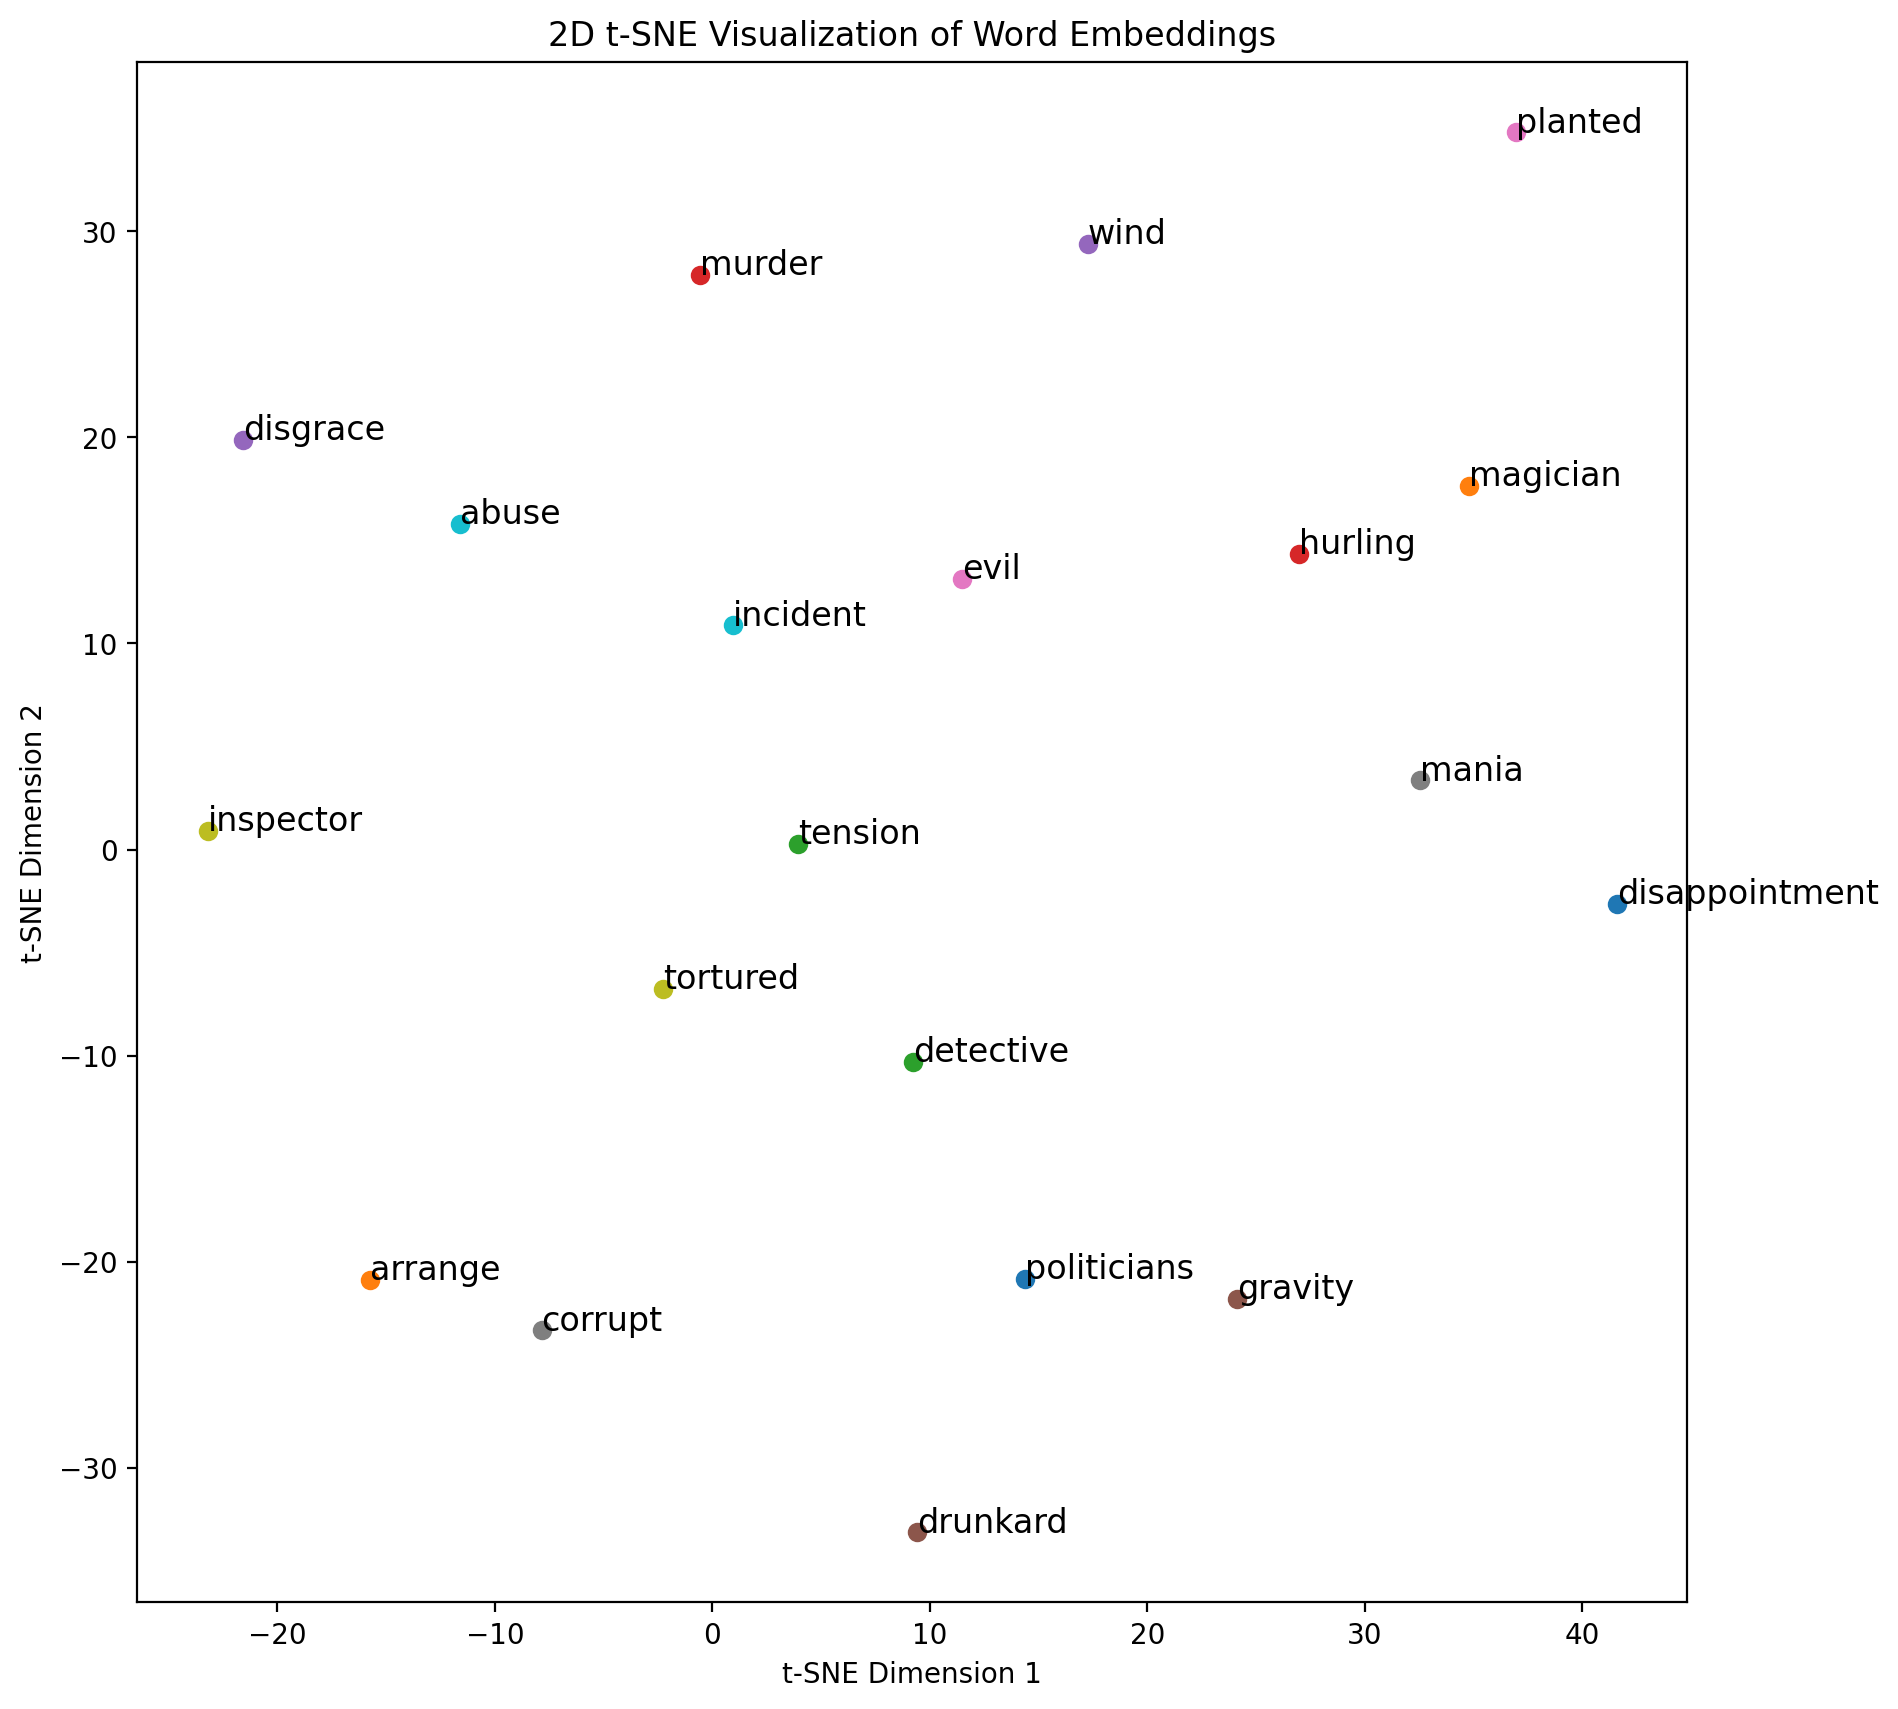

In [31]:
# Filter selected_words to match only words in selected_indices
filtered_words = [word for word in selected_words if word in stoi]
selected_indices = [stoi[word] for word in filtered_words]

# Extract embeddings only for the filtered words
embeddings = model.emb.weight.detach().cpu().numpy()[selected_indices]

# Perform t-SNE on the selected embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=min(len(embeddings) - 1, 5))
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the filtered words
plt.figure(figsize=(10, 10))
for i, word in enumerate(filtered_words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=12)

plt.title("2D t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
